# Bianco's CNN color constancy model recreated

#### CS 7180 - Advanced Perception
#### Di Zhang & Prakriti Pritmani
#### Oct 14, 2023

## imported packages

In [235]:
import cv2
import scipy.io
import glob
from random import randint
import progressbar as pb
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras import layers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.initializers import glorot_uniform
from keras import backend as K
from keras.preprocessing import image
from keras.models import model_from_json
from scipy.io import loadmat
import glob


## Helper Functions

In [236]:
#define progress timer class
class progress_timer:

    def __init__(self, n_iter, description="Something"):
        self.n_iter         = n_iter
        self.iter           = 0
        self.description    = description + ': '
        self.timer          = None
        self.initialize()

    def initialize(self):
        #initialize timer
        widgets = [self.description, pb.Percentage(), ' ',   
                   pb.Bar('=', '[', ']'), ' ', pb.ETA()]
        self.timer = pb.ProgressBar(widgets=widgets, maxval=self.n_iter).start()

    def update(self, q=1):
        #update timer
        self.timer.update(self.iter)
        self.iter += q

    def finish(self):
        #end timer
        self.timer.finish()
        

## Data Preprocesssing

In [237]:
# generate both train data and test data, split the images to 32 by 32 patches, save the normalized images
def generate_data(train_size, patch_size, mode, camera):
    
    if camera == "D5200":
        key = 'groundtruth_illuminants'
        format = 'PNG'
        mat_path = '/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/NikonD5200_gt.mat'
        if mode == "train":
            path = '/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/PNG_D5200_train/'
        elif mode == "test":
            path = '/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/PNG_D5200_test/'
        else:
            print("wrong mode")
    
    elif camera == "D40":
        key = 'groundtruth_illuminants'
        format = 'NEF'
        mat_path = '/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/NikonD40_gt.mat'
        if mode == "train":
            path = '/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/RAW_train/'
        elif mode == "test":
            path = '/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/RAW_test/'
        else:
            print("wrong mode")
    
    else:
        print("Camera not included")

    illum_mat = scipy.io.loadmat(mat_path, squeeze_me = True, struct_as_record = False)
    ground_truth_illum = illum_mat[key]
    
    flist = glob.glob(path + '*.' + format)
    number_of_gt = len(flist)
    
    pt = progress_timer(n_iter = number_of_gt, description = 'Generating ' + mode + ' Data')
    
    patches_per_image = int(train_size/number_of_gt)

    X_origin, Y_origin, name_train = [], [], []
    i = 0
    patch_r, patch_c = patch_size

    while (i < number_of_gt):
        
        image_number = flist[i]
        index = (image_number.replace(path ,'')).replace('.' + format, '').replace('Nikon'+ camera+ '_', '')
        
        image = cv2.imread(image_number)
        n_r, n_c, _ = np.shape(image)

        total_patch = int(((n_r - n_r%patch_r)/patch_r)*((n_c - n_c%patch_c)/patch_c))
        
        img_resize = cv2.resize(image, ((n_r - n_r%patch_r), (n_c - n_c%patch_c)))
        img_reshape = np.reshape(img_resize, (int(patch_r), -1, 3))
        
        #Create CLAHE object
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
        for j in range (0, patches_per_image):
            
            rd = randint(0, total_patch - 1)
            img_patch = img_reshape[0:patch_r, rd*patch_c:(rd+1)*patch_c]
            
            #Convert image to Lab to perform contrast normalizing
            lab= cv2.cvtColor(img_patch, cv2.COLOR_BGR2LAB)
            
            #Contrast normalizing(Stretching)
            l, a, b = cv2.split(lab)
            cl = clahe.apply(l)
            clab = cv2.merge((cl, a, b))
            
            #Convert back to BGR
            img_patch = cv2.cvtColor(clab, cv2.COLOR_LAB2BGR)
            
            img_patch = cv2.cvtColor(img_patch, cv2.COLOR_BGR2RGB)

            X_origin.append(img_patch)
            Y_origin.append(ground_truth_illum[int(index) - 1])

        name_train.append('%04d' % (int(index) - 1))
             
        i += 1
        
        pt.update()
 
    X_origin = np.asarray(X_origin)
    Y_origin = np.asarray(Y_origin)
    
    X_origin = X_origin/255
    max_Y = np.amax(Y_origin, 1)
    Y_origin[:, 0] = Y_origin[:, 0]/max_Y
    Y_origin[:, 1] = Y_origin[:, 1]/max_Y
    Y_origin[:, 2] = Y_origin[:, 2]/max_Y
    
    seed = randint(1, 5000)
    np.random.seed(seed)
    X_origin = np.random.permutation(X_origin)
    
    np.random.seed(seed)
    Y_origin = np.random.permutation(Y_origin)
    
    pt.finish()
    
    return X_origin, Y_origin, name_train

In [238]:
# generate data from Nikon_D5200 PNG images
# get the training data patches
train_size = 18000
patch_size = (32, 32)

X_train_D5200, Y_train_D5200, name_train_D5200 = generate_data(train_size, patch_size, "train", "D5200")
np.save('X_train_D5200.npy', X_train_D5200)
np.save('Y_train_D5200.npy', Y_train_D5200) 
np.save('name_train_D5200.npy', name_train_D5200)

# get the test data patches
test_size = 2000
patch_size = (32, 32)

X_test_D5200, Y_test_D5200, name_test_D5200 = generate_data(test_size, patch_size, "test", "D5200")
np.save('X_test_D5200.npy', X_test_D5200)
np.save('Y_test_D5200.npy', Y_test_D5200) 
np.save('name_test_D5200.npy', name_test_D5200)

Generating train Data: 100% [===================================] Time: 0:00:41
Generating test Data: 100% [====================================] Time: 0:00:04


In [239]:
# generate data from Nikon_D40 NEF images

# get the training data patches
train_size = 8000
patch_size = (32, 32)

X_train_D40, Y_train_D40, name_train_D40 = generate_data(train_size, patch_size, "train", "D40")
np.save('X_train_D40.npy', X_train_D40)
np.save('Y_train_D40.npy', Y_train_D40) 
np.save('name_train_D40.npy', name_train_D40)

# get the test data patches
test_size = 32000
patch_size = (32, 32)

X_test_D40, Y_test_D40, name_test_D40 = generate_data(test_size, patch_size, "test", "D40")
np.save('X_test_D40.npy', X_test_D40)
np.save('Y_test_D40.npy', Y_test_D40) 
np.save('name_test_D40.npy', name_test_D40)


Generating train Data: 100% [===================================] Time: 0:00:00
Generating test Data: 100% [====================================] Time: 0:00:01


## Model

In [240]:
# constract color constancy training model
def ColorNet(input_shape, channels = 3):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(240, (1, 1), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(name = 'bn_conv1')(X)
    
    X = MaxPooling2D((8, 8), strides=(8, 8))(X)
  
    # output layer
    X = Flatten()(X)
    X = Dense(40, activation='relu', name='fc' + str(40))(X)
    X = Dropout(rate = 0.5)(X)
    
    X = Dense(channels, activation=None, name='fc' + str(channels))(X)
    
    # Create model
    color_model = Model(inputs = X_input, outputs = X, name='ColorNet')
    
    return color_model

## Training

In [241]:
# training the model and save model structure and weights
def train_mode(camera_model, X_train, Y_train,  X_test, Y_test):
    loss_cos_sim = tf.keras.losses.CosineSimilarity()
    rmsprop = optimizers.legacy.RMSprop(lr = 0.001, rho=0.9, epsilon=None, decay=0.0)

    cc_model = ColorNet(input_shape = X_train.shape[1:4])
    cc_model.compile(optimizer = 'Adam', loss = loss_cos_sim , metrics = ['accuracy'])

    estimate = cc_model.fit(X_train, Y_train, validation_split = 0.3333, epochs = 20, batch_size = 160)

    preds = cc_model.evaluate(X_test, Y_test)
    print()
    print ("Loss = " + str(preds[0]))
    print ("Test Accuracy = " + str(preds[1]))

    # serialize model to JSON
    model_json = cc_model.to_json()
    with open("cc_model_" + camera_model + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    cc_model.save_weights("cc_model_" + camera_model + ".h5")
    print("Saved model to disk")
    

In [242]:
train_mode("D5200", X_train_D5200, Y_train_D5200, X_test_D5200, Y_test_D5200)

/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/.venv/lib/python3.11/site-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
75/75 [==============================] - 8s 104ms/step - loss: -0.9537 - accuracy: 0.9283 - val_loss: -0.9860 - val_accuracy: 0.9952
Epoch 2/20
75/75 [==============================] - 8s 102ms/step - loss: -0.9830 - accuracy: 0.9858 - val_loss: -0.9882 - val_accuracy: 0.9957
Epoch 3/20
75/75 [==============================] - 8s 103ms/step - loss: -0.9874 - accuracy: 0.9914 - val_loss: -0.9901 - val_accuracy: 0.9957
Epoch 4/20
75/75 [==============================] - 8s 104ms/step - loss: -0.9897 - accuracy: 0.9927 - val_loss: -0.9926 - val_accuracy: 0.9957
Epoch 5/20
75/75 [==============================] - 8s 104ms/step - loss: -0.9907 - accuracy: 0.9896 - val_loss: -0.9881 - val_accuracy: 0.9945
Epoch 6/20
75/75 [==============================] - 8s 104ms/step - loss: -0.9915 - accuracy: 0.9909 - val_loss: -0.9903 - val_accuracy: 0.9952
Epoch 7/20
75/75 [==============================] - 8s 106ms/step - loss: -0.9923 - accuracy: 0.9896 - val_loss: -0.9791 - val_accuracy:

In [243]:
train_mode("D40", X_train_D40, Y_train_D40, X_test_D40, Y_test_D40)

Epoch 1/20
34/34 [==============================] - 4s 107ms/step - loss: -0.8808 - accuracy: 0.6404 - val_loss: -0.9726 - val_accuracy: 0.9771
Epoch 2/20
34/34 [==============================] - 4s 106ms/step - loss: -0.9418 - accuracy: 0.7581 - val_loss: -0.9821 - val_accuracy: 0.9771
Epoch 3/20
34/34 [==============================] - 4s 106ms/step - loss: -0.9575 - accuracy: 0.8521 - val_loss: -0.9839 - val_accuracy: 0.9771
Epoch 4/20
34/34 [==============================] - 4s 106ms/step - loss: -0.9683 - accuracy: 0.9036 - val_loss: -0.9862 - val_accuracy: 0.9771
Epoch 5/20
34/34 [==============================] - 4s 104ms/step - loss: -0.9745 - accuracy: 0.9325 - val_loss: -0.9873 - val_accuracy: 0.9771
Epoch 6/20
34/34 [==============================] - 4s 105ms/step - loss: -0.9794 - accuracy: 0.9542 - val_loss: -0.9883 - val_accuracy: 0.9771
Epoch 7/20
34/34 [==============================] - 4s 103ms/step - loss: -0.9805 - accuracy: 0.9595 - val_loss: -0.9886 - val_accuracy:

## Constructing Images Based on Trained Model

In [244]:
# linear image transformation
def linear_transform(channel_sRGB, gamma, f, s, T):
    m, n = channel_sRGB.shape
    channel_linear = channel_sRGB; channel_sRGB_norm = channel_sRGB/255
    for i in range(0, m):
        for j in range(0, n):
            if (T < channel_sRGB_norm[i][j] < 1):
                channel_linear[i][j] = ((channel_sRGB_norm[i][j] + f)/(1 + f))**(1/gamma)
            elif (0 <= channel_sRGB_norm[i][j] <= T):
                channel_linear[i][j] = channel_sRGB_norm[i][j]/s
                
    channel_linear = 255*channel_linear; 
    channel_linear[channel_linear > 255] = 255;            
    return channel_linear

# non-linear image transformation
def non_linear_transform(channel, gamma, f, s, t):
    m, n = channel.shape
    channel_gamma_cor = channel; channel_norm = channel/255
    for i in range(0, m):
        for j in range(0, n):
            if (t < channel_norm[i][j] < 1):
                channel_gamma_cor[i][j] = (1 + f)*(channel_norm[i][j]**gamma) - f
            elif (0 <= channel_norm[i][j] <= t):
                channel_gamma_cor[i][j] = s*channel_norm[i][j]
    
    channel_gamma_cor = channel_gamma_cor*255; 
    channel_gamma_cor[channel_gamma_cor > 255] = 255;       
    return channel_gamma_cor
    

In [245]:
# gamma decoder for adobe RGB and sRGB- compensate for the non-linear response of the human visual system to change brightness
def gamma_decode(B_gamma, G_gamma, R_gamma, decoding_type):
    B_gamma = B_gamma/255; G_gamma = G_gamma/255; R_gamma = R_gamma/255; 
    if decoding_type == 'AdobeRGB':
        #Adobe RGB
        gamma = 1/2.2
        B_gamma_decode = 255*(B_gamma**(1/gamma)) 
        G_gamma_decode = 255*(G_gamma**(1/gamma))
        R_gamma_decode = 255*(R_gamma**(1/gamma))
        return (B_gamma_decode, G_gamma_decode, R_gamma_decode)
    elif decoding_type == 'sRGB':
        #sRGB
        gamma = 1/2.4
        f = 0.055; s = 12.92; T = 0.04045
        B_gamma_inverse = linear_transform(B_gamma, gamma, f, s, T)
        G_gamma_inverse = linear_transform(G_gamma, gamma, f, s, T)
        R_gamma_inverse = linear_transform(R_gamma, gamma, f, s, T)
        return (B_gamma_inverse, G_gamma_inverse, R_gamma_inverse)
    
# gamma decoder for adobe RGB and sRGB- compensate for the non-linear response of the human visual system to change brightness
def gamma_encode(B_channel, G_channel, R_channel, encoding_type):
    B_channel = B_channel/255; G_channel = G_channel/255; R_channel = R_channel/255
    #Non linear encoding
    if encoding_type == 'AdobeRGB':
        #Adobe RGB
        gamma = 1/2.2
        if np.all(B_channel <= 0):
            B_gamma_cor = (B_channel**(gamma + 0j))
            B_gamma_cor = 255*(abs(B_gamma_cor))
        else:
            B_gamma_cor = 255*(B_channel**gamma)
            
        if np.all(G_channel <= 0):
            G_gamma_cor = (G_channel**(gamma + 0j))
            G_gamma_cor = 255*(abs(G_gamma_cor))
        else:
            G_gamma_cor = 255*(G_channel**gamma)
            
        if np.all(R_channel <= 0):
            R_gamma_cor = (R_channel**(gamma + 0j))
            R_gamma_cor = 255*(abs(R_gamma_cor))
        else:
            R_gamma_cor = 255*(R_channel**gamma)
        
        return (B_gamma_cor, G_gamma_cor, R_gamma_cor)
    elif encoding_type == 'sRGB':
        #sRGB
        gamma = 1/2.4
        f = 0.055; s = 12.92; t = 0.0031308
        B_gamma_cor = non_linear_transform(B_channel, gamma, f, s, t)
        G_gamma_cor = non_linear_transform(G_channel, gamma, f, s, t)
        R_gamma_cor = non_linear_transform(R_channel, gamma, f, s, t)
        return (B_gamma_cor, G_gamma_cor, R_gamma_cor)

In [285]:
# This method loads the trained model and uses local image patches to generate illuminatation estimates for the input image and 
# returns estimated illumination map

def create_illumination_map(image, patch_size, camera):
    loss_cos_sim = tf.keras.losses.CosineSimilarity()
    # load cc_model
    model_path = '/Users/dizhang/Desktop/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/cc_model' + camera + '.h5'
    model_json_path = '/Users/dizhang/Desktop/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/cc_model' + camera + '.json'

    json_file = open(model_json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    
    cc_model = model_from_json(loaded_model_json)
    
    cc_model.load_weights(model_path)
    cc_model.compile(optimizer='Adam', loss=loss_cos_sim, metrics = ['accuracy'])
    
    n_r, n_c, _ = image.shape
    patch_r, patch_c = patch_size
    
    total_patch = int(((n_r - n_r%patch_r)/patch_r)*((n_c - n_c%patch_c)/patch_c))
    
    img_resize = cv2.resize(image, ((n_r - n_r%patch_r), (n_c - n_c%patch_c)))
    img_reshape = np.reshape(img_resize, (int(patch_r), -1, 3))
    
    illum_estimate = []
    for i in range(total_patch):    
        img_patch = img_reshape[0:patch_r, i*patch_c:(i+1)*patch_c]
        patch_cvt = cv2.cvtColor(img_patch, cv2.COLOR_BGR2RGB)
        patch_cvt = np.expand_dims(patch_cvt, axis=0)
        illum_estimate.append(cc_model.predict(patch_cvt))
    illum_estimate = np.asarray(illum_estimate)
    illum_map = np.reshape(illum_estimate, (int((n_r - n_r%patch_r)/patch_r), int((n_c - n_c%patch_c)/patch_c), 3))
    print('generated illum_map', illum_map)
    return illum_map

In [286]:
# avarage pooling - calculate the average illumination in an image
def pool_function(illum_map, pool_size, stride,  mode):
    n_h, n_w, n_c = illum_map.shape
    pool_h, pool_w = pool_size
    stride_h, stride_w = stride
    
    # Define the dimensions of the output
    h_out = int(1 + (n_h - pool_h) / stride_h)
    w_out = int(1 + (n_w - pool_w) / stride_w)
    c_out = n_c
    
    pool_out = np.zeros((h_out, w_out, c_out))
    
    for h in range(h_out):                     
        for w in range(w_out):                 
            for c in range (c_out):            
                
                vert_start = h*stride_h
                vert_end = h*stride_h + pool_h
                horiz_start = w*stride_w
                horiz_end = w*stride_w + pool_w
                    
                slice_window = illum_map[vert_start:vert_end, horiz_start:horiz_end, c]
                    
                if mode == "std":
                    pool_out[h, w, c] = np.std(slice_window)
                elif mode == "average":
                    pool_out[h, w, c] = np.mean(slice_window)
    return pool_out

In [287]:
# This method returns average of all image patches estimated by the ColorNet model
def local_2_global(image_name, image, patch_size, camera):
    n_r, n_c, _ = image.shape
    
    illum_map = create_illumination_map(image, patch_size, camera)      #patch_size = (32, 32)
    
    #Gaussian Smooting with 5x5 kernel
    illum_map_smoothed = cv2.GaussianBlur(illum_map, (5,5), cv2.BORDER_DEFAULT)
    
    #Perform median pooling
    median_pooling = np.zeros((1, 3))
    median_pooling[0, 0] = np.median(illum_map_smoothed[:, :, 0])
    median_pooling[0, 1] = np.median(illum_map_smoothed[:, :, 1])
    median_pooling[0, 2] = np.median(illum_map_smoothed[:, :, 2])
        
    #Perform avarage pooling 
    n_r, n_c, _ = illum_map.shape
    pool_size = (int(n_r/3), int(n_c/3))
    stride = (int(n_r/3), int(n_c/3))
    average_pooling = pool_function(illum_map, pool_size, stride, mode = 'average')
    
    average_pooling[0, 0] = np.mean(average_pooling[:, :, 0])
    average_pooling[0, 1] = np.mean(average_pooling[:, :, 1])
    average_pooling[0, 2] = np.mean(average_pooling[:, :, 2])

    illum_global = median_pooling
    #illum_global = average_pooling
    return illum_global
    

In [288]:
# This is an abstract method that performs white balancing using the illumation estimate map generated by the ColorNet model
def colornet_white_balancing(img, image_name, patch_size, camera):

    m, n, _ = img.shape
    B_channel, G_channel, R_channel = cv2.split(img)
    Color_space = 'AdobeRGB'
 
    #Undo Gamma Correction
    B_channel, G_channel, R_channel = gamma_decode(B_channel, G_channel, R_channel, Color_space)
    
    #Compute local illuminant map then aggregate to global illuminant
    illum_global = local_2_global(image_name, img, patch_size, camera)
    
    #Gain of red and  blue channels
    alpha = np.max(illum_global)/illum_global[0, 2]
    beta = np.max(illum_global)/illum_global[0, 1]
    ceta = np.max(illum_global)/illum_global[0, 0]
        
    #Corrected Image
    B_cor = alpha*B_channel
    G_cor = beta*G_channel
    R_cor = ceta*R_channel
        
    #Gamma correction to display
    B_cor, G_cor, R_cor = gamma_encode(B_cor, G_cor, R_cor, Color_space)
    B_cor[B_cor > 255] = 255
    G_cor[G_cor > 255] = 255
    R_cor[R_cor > 255] = 255
        
    #Convert to uint8 to display
    B_cor = B_cor.astype(np.uint8)
    G_cor = G_cor.astype(np.uint8)
    R_cor = R_cor.astype(np.uint8)
    img_cor = cv2.merge((B_cor, G_cor, R_cor))
    
    return img_cor

In [289]:
# get all the images for the specified folder support types of images NEF and CR2
def get_images_fullpath(img_folder_path, mode):
    if (mode == "NEF"):
        images_fullpath = glob.glob(img_folder_path + "**/*.NEF", recursive=True)
    elif (mode == "CR2"):
        images_fullpath = glob.glob(img_folder_path + "**/*.CR2", recursive=True)
    elif (mode == "PNG"):
        images_fullpath = glob.glob(img_folder_path + "**/*.PNG", recursive=True)

    images_fullpath.sort(key=lambda x: x.split('/')[-1].split('.')[0])
    return images_fullpath

# load ground truth illuminant and convert to convert to chromaticity
def load_groundtruth_illuminant(file_path):
    real_illum = loadmat(file_path)
    real_rgb = real_illum["groundtruth_illuminants"]
    real_rgb = real_rgb / real_rgb[:, 1][:, np.newaxis]
    return real_rgb

In [290]:
# get ground truth illumination and get all the pathes for the images for D5200
real_rgb_D5200 = load_groundtruth_illuminant('/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/NikonD5200_gt.mat')
db_images_D5200 = get_images_fullpath(img_folder_path = '/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/PNG_D5200_test', mode="PNG")
test_image_indexs_D5200 = np.random.choice(len(db_images_D5200), 8)
# initilize arrays for input images, ground truth image, model images
input_imgs_D5200  = []
gt_imgs_D5200  = []
cnn_imgs_D5200  = []

In [291]:
# get ground truth illumination and get all the pathes for the images for D40
real_rgb_D40 = load_groundtruth_illuminant('/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/NikonD40_gt.mat')
db_images_D40 = get_images_fullpath(img_folder_path = '/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/RAW_test', mode="NEF")
test_image_indexs_D40 = np.random.choice(len(db_images_D40), 8)
# initilize arrays for input images, ground truth image, model images
input_imgs_D40 = []
gt_imgs_D40 = []
cnn_imgs_D40 = []

In [292]:

# convert images to 8 bit
def convert_to_8bit(arr, clip_percentile):
    arr = np.clip(arr * (255.0 / np.percentile(arr, 100 - clip_percentile, keepdims=True)), 0, 255)
    return arr.astype(np.uint8)

In [293]:

# white balalance the image to get a more natural image
def white_balance_image(img12, bit, Gain_R, Gain_G, Gain_B):    
    img12 = (img12/(2**bit - 1))*100.0; #12bit data
    image = convert_to_8bit(img12, 2.5)
    image = (cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            
    image[:, :, 0] = np.minimum(image[:, :, 0] * Gain_R,255)
    image[:, :, 1] = np.minimum(image[:, :, 1] * Gain_G,255)
    image[:, :, 2] = np.minimum(image[:, :, 2] * Gain_B,255)
            
    gamma = 1/2.2
    image = pow(image, gamma) * (255.0/pow(255,gamma))
    image = np.array(image,dtype=np.uint8)
    image8 = (cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return image8

In [294]:
# get input images
def get_input_image(img12,bit):
    img12 = (img12/(2**bit - 1))*100.0; #12bit data
    image = convert_to_8bit(img12, 2.5)
    image = (cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    gamma = 1/2.2
    image = pow(image, gamma) * (255.0/pow(255,gamma))
    image = np.array(image,dtype=np.uint8)
    image8 = (cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return image8

In [295]:
# process input, ground truth and model generated images
%time
def generate_output_images(real_rgb, test_image_indexs, db_images, input_imgs, gt_imgs, cnn_imgs, camera):
    bit = 12
    patch_size = (32,32)
    for it,idx in enumerate(test_image_indexs):
        print(f'---------------- Start of Iteration: {it+1} ----------------')
        # Step 1: Convert 12-bit images to 8-bit images
        img12 = cv2.imread(db_images[idx],cv2.IMREAD_UNCHANGED).astype(np.float32)
        img12 = cv2.resize(img12, (512, 512))
        inp_image = get_input_image(img12.copy(),bit=bit)
        input_imgs.append(inp_image)
        
        # Step 2: Generate Ground truth
        Gain_R= float(np.max(real_rgb[idx]))/float((real_rgb[idx][0]))
        Gain_G= float(np.max(real_rgb[idx]))/float((real_rgb[idx][1]))
        Gain_B= float(np.max(real_rgb[idx]))/float((real_rgb[idx][2]))
        gt_image = white_balance_image(img12, bit, Gain_R, Gain_G, Gain_B)
        gt_imgs.append(gt_image)
        
        #Step 3: Generate ColorNet output
        out_img = colornet_white_balancing(inp_image, 'test', patch_size, camera)
        cnn_imgs.append(out_img)
        print(f'---------------- End of Iteration: {it+1} ----------------')

CPU times: user 0 ns, sys: 1e+03 ns, total: 1e+03 ns
Wall time: 3.81 µs


In [296]:
generate_output_images(real_rgb_D40, test_image_indexs_D40, db_images_D40, input_imgs_D40, gt_imgs_D40, cnn_imgs_D40, "_D40")

---------------- Start of Iteration: 1 ----------------
1/1 [==============================] - 0s 8ms/step
generated illum_map [[[ 4665.368    6622.097    1540.729  ]
  [10063.51    13088.364    3417.4026 ]
  [ 7198.1377   9353.104    2446.3638 ]
  [ 2542.843    3814.9016    990.08606]
  [ 8054.8057  10323.431    2737.219  ]
  [ 1248.0969   3044.4954   1053.2156 ]
  [ 1190.7471   2983.1348   1301.8816 ]
  [ 6302.891    8140.5356   2287.6628 ]
  [10159.543   12795.413    3510.3972 ]
  [ 7230.638    9722.107    2507.3943 ]
  [ 3919.0808   5741.2266   1475.83   ]
  [ 2092.431    3433.87      967.4694 ]
  [ 1805.0607   3072.329     789.01685]
  [ 4016.9438   5643.9683   1627.3656 ]
  [ 6083.4023   7948.7837   2292.196  ]
  [ 5280.7363   7097.291    2249.561  ]]

 [[ 3941.278    5758.2495   1308.479  ]
  [ 9398.797   12225.687    3181.5376 ]
  [ 7445.942    9628.717    2521.4958 ]
  [ 2536.7253   3844.5437    981.2921 ]
  [ 8191.218   10483.599    2788.5676 ]
  [ 1123.9742   2893.7942   103

In [297]:
generate_output_images(real_rgb_D5200, test_image_indexs_D5200, db_images_D5200, input_imgs_D5200, gt_imgs_D5200, cnn_imgs_D5200, "_D5200")

---------------- Start of Iteration: 1 ----------------


1/1 [==============================] - 0s 8ms/step
generated illum_map [[[1723.4017  5379.5186  2984.1309 ]
  [1476.7716  4694.327   2563.2322 ]
  [1231.5651  4564.448   2273.0417 ]
  [1348.6929  4640.4453  2440.7275 ]
  [1590.2977  5286.699   2850.8152 ]
  [1387.0841  4870.9106  2544.337  ]
  [ 728.4343  3542.6172  1550.3904 ]
  [1139.3856  4902.003   2311.5989 ]
  [ 880.0181  4215.307    455.91058]
  [ 812.5902  3938.4785   256.09946]
  [ 841.3612  3944.0173  1044.2983 ]
  [1120.7238  3974.0632  2029.3876 ]
  [1208.2848  4113.166   2156.867  ]
  [1170.9238  4115.548   2103.0847 ]
  [1224.5844  4494.985   2263.6318 ]
  [ 793.55804 3676.9084  1642.1328 ]]

 [[1682.9648  5290.1562  2917.864  ]
  [1626.6814  5042.7646  2794.7026 ]
  [1304.9717  4760.5186  2398.3284 ]
  [1261.5793  4487.918   2308.909  ]
  [1578.4562  5070.084   2781.7021 ]
  [1447.5823  4751.515   2578.739  ]
  [ 780.3294  3700.189   1630.2473 ]
  [ 783.227   3858.2031  1669.7473 ]
  [ 973.3926  4466.722    806.84125]
  

## Result

In [298]:
import matplotlib.pyplot as plt
%matplotlib inline

In [299]:
# ploting input, ground truth and model output images and compare them side by side
def output_plot(input_imgs, gt_imgs, cnn_imgs, camera):
    k=1
    fig = plt.figure(figsize=(10,10))
    for i in range(len(input_imgs)):
        plt.subplot(8,3,k)
        if k==1:
            plt.title("Input Image")
        plt.imshow(cv2.cvtColor(input_imgs[i], cv2.COLOR_BGR2RGB))
        k+=1
        plt.xticks([])
        plt.yticks([])
        plt.subplot(8,3,k)

        if k==2:
            plt.title("Ground Truth")
        plt.imshow(cv2.cvtColor(gt_imgs[i], cv2.COLOR_BGR2RGB))
        k+=1
        plt.xticks([])
        plt.yticks([])
        plt.subplot(8,3,k)
        if k==3:
            plt.title("Model Output")
        plt.imshow(cv2.cvtColor(cnn_imgs[i], cv2.COLOR_BGR2RGB))
        k+=1
        plt.xticks([])
        plt.yticks([])
    fig.tight_layout()
    # fig.title("Input Image - Ground Truth - Model Output")
    fig.show('/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/MicrosoftTeams-image.png')
    fig.savefig(fname='output_' + camera + '.png')

/var/folders/v9/nypmc_px3rq06tbvfnmbys080000gn/T/ipykernel_2591/738457771.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show('/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/MicrosoftTeams-image.png')


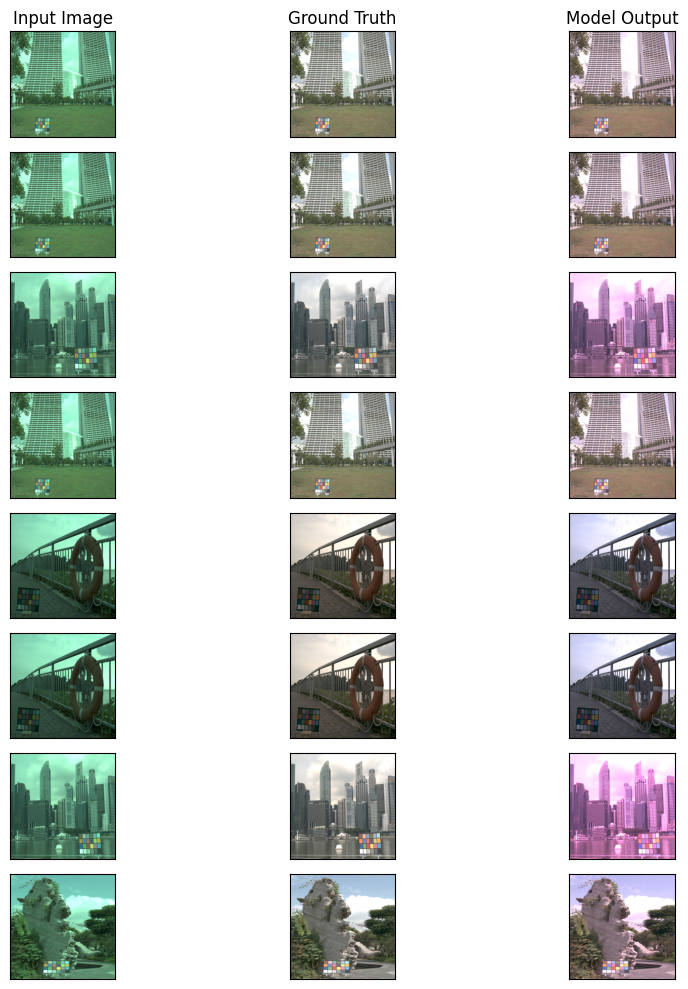

In [300]:
# ploting D5200 input, ground truth and model output images and compare them side by side
output_plot(input_imgs_D5200, gt_imgs_D5200, cnn_imgs_D5200, "D5200")


/var/folders/v9/nypmc_px3rq06tbvfnmbys080000gn/T/ipykernel_2591/738457771.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show('/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/MicrosoftTeams-image.png')


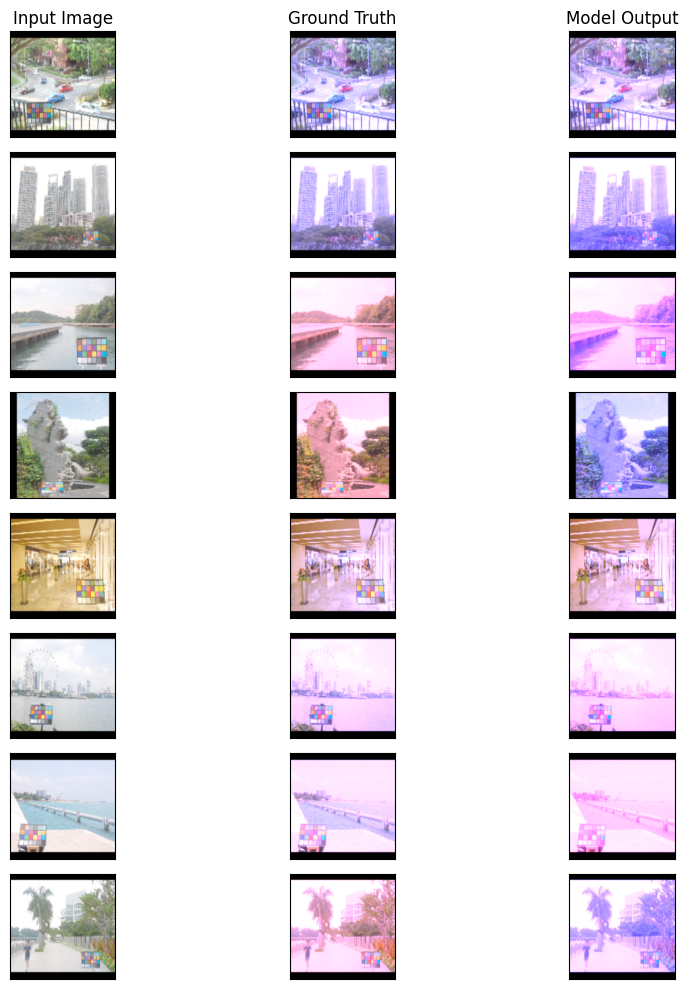

In [301]:
# ploting D40 input, ground truth and model output images and compare them side by side
output_plot(input_imgs_D40, gt_imgs_D40, cnn_imgs_D40, "D40")

In [302]:
image = cv2.imread('/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/PNG_D5200_test/NikonD5200_0185.PNG')
n_r, n_c, _ = np.shape(image)
print(n_r, n_c, _)

2010 3018 3


In [303]:
image = cv2.imread('/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/RAW_test/NikonD40_0083.NEF')
n_r, n_c, _ = np.shape(image)
print(n_r, n_c, _)

120 160 3


In [304]:
illum_mat = scipy.io.loadmat("/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/NikonD40_gt.mat", squeeze_me = True, struct_as_record = False)
print(illum_mat['groundtruth_illuminants'])

[[0.31573503 0.80196495 0.50711302]
 [0.71584051 0.65978893 0.22858463]
 [0.6401792  0.72669397 0.24917155]
 [0.68366943 0.70238395 0.19812341]
 [0.64799829 0.72689885 0.22741215]
 [0.68742933 0.70065947 0.19109481]
 [0.58582429 0.75966871 0.28233553]
 [0.65306992 0.72051871 0.23313614]
 [0.62943596 0.7344369  0.25379678]
 [0.30568666 0.76048019 0.57290973]
 [0.60946397 0.74670881 0.26642001]
 [0.67740969 0.70519839 0.2093116 ]
 [0.3365085  0.78595192 0.51869221]
 [0.31900177 0.76462157 0.55999261]
 [0.336823   0.77982173 0.52766309]
 [0.3395896  0.77109005 0.53860843]
 [0.32669283 0.76567184 0.55409243]
 [0.35202124 0.77348698 0.52706635]
 [0.3438883  0.77327423 0.53271738]
 [0.33047333 0.7595849  0.56019475]
 [0.34810527 0.7721705  0.53157826]
 [0.33565623 0.77278959 0.53863823]
 [0.36259208 0.78804535 0.49750528]
 [0.34041327 0.83630226 0.42978755]
 [0.34603406 0.82323127 0.45005633]
 [0.42812574 0.79748391 0.42512088]
 [0.28612587 0.75206178 0.59374664]
 [0.35140974 0.77306266 0.52